slabMesh example notebook
-------

Eric Lindsey, Oct 2020

Runs a series of commands to make a triangular mesh for a portion of the Rakhine megathrust


In [1]:
# If using conda, use below line to install packages (only run once). 
# May not work on Windows; if this command hangs for longer than a few minutes, 
# cancel it and install the packages through your Anaconda package manager or another method.

# conda install -c conda-forge numpy scipy netcdf4 matplotlib ipyml meshpy

In [2]:
#default python
from __future__ import division
from __future__ import absolute_import
from six.moves import range

# required anaconda packages (conda install): numpy, scipy, netcdf4, matplotlib, ipympl
import numpy as np
import numpy.linalg as la
from scipy import interpolate
import scipy.io as scio
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #requires ipympl package

# available from conda forge (conda install -c conda-forge meshpy)
import meshpy.triangle as triangle

# local import
import slabMesh

# set modules to reload when changed
%load_ext autoreload
%autoreload 2

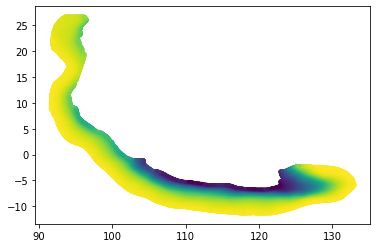

-673.2764 -3.1468403


In [3]:
# load the slab depth data points
fname = 'sum_slab2_dep_02.23.18.grd'
X,Y,Z = slabMesh.load_slab2_grid(fname)

%matplotlib inline
# make a plot of the slab points, and print min/max of depths
plt.scatter(X,Y,5,Z)
plt.show()
print(np.min(Z),np.max(Z))

(300, 360)


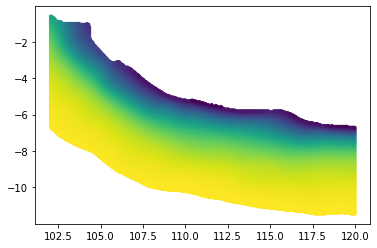

-661.98865 0.0


In [4]:
# crop a section of the fault

# example for a N-S trending segment:
# trendNS = True
# Xcrop,Ycrop,Zcrop_orig=slabMesh.crop_rectangle(X,Y,Z,90,100,13.95,25.1)

# example for an E-W trending segment:
trendNS = False
Xcrop,Ycrop,Zcrop_orig=slabMesh.crop_rectangle(X,Y,Z,102,120,-15,0)

#offset the depth values, so they are relative to the seafloor (optional)
Zcrop=slabMesh.slabtop_at_zero(Zcrop_orig)

print(np.shape(Xcrop))
plt.scatter(Xcrop,Ycrop,5,Zcrop)
plt.show()
print(np.min(Zcrop),np.max(Zcrop))

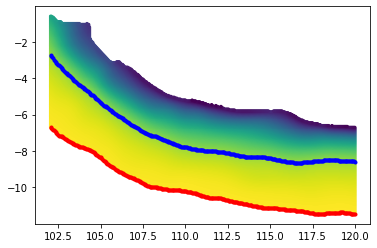

In [5]:
# get boundary points, from slab top to a specified depth.
# this currently relies on an assumption about the strike/dip direction.
# Need to generalize for other megathrusts.

maxdepth = 100
top=[]
bottom=[]
if trendNS:
    for i in range(np.shape(Zcrop)[0]):
        row=Zcrop[i,:]
        validdata=np.where(row>-maxdepth)[0] #warning generated due to NaN values. They are ignored anyway
        if len(validdata>0):
            if Zcrop[i,validdata[0]] > Zcrop[i,validdata[-1]]:
                top.append([i,validdata[0]])
                bottom.append([i,validdata[-1]])
            else:
                bottom.append([i,validdata[0]])
                top.append([i,validdata[-1]]) 
else:
    for i in range(np.shape(Zcrop)[1]):
        row = Zcrop[:,i]
        validdata=np.where(row>-maxdepth)[0] #warning generated due to NaN values. They are ignored anyway
        if len(validdata>0):
            if Zcrop[validdata[0],i] > Zcrop[validdata[-1],i]:
                top.append([validdata[0],i])
                bottom.append([validdata[-1],i])
            else:
                bottom.append([validdata[0],i])
                top.append([validdata[-1],i])

# must be missing a simpler way to do this here... argh
top=np.array(top)
bottom=np.array(bottom)
Xtop=Xcrop[top[:,0],top[:,1]]
Ytop=Ycrop[top[:,0],top[:,1]]
Xbottom=Xcrop[bottom[:,0],bottom[:,1]]
Ybottom=Ycrop[bottom[:,0],bottom[:,1]]


plt.scatter(Xcrop,Ycrop,5,Zcrop)
plt.plot(Xtop,Ytop,'r.')
plt.plot(Xbottom,Ybottom,'b.')
plt.show()

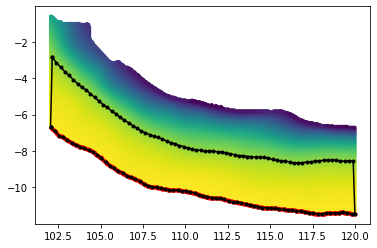

In [6]:
# extend the fault up to the surface by interpolation - special case for Bangladesh

# only set this to be true if you are working on the Bangladesh megathrust
extend_to_surface = False

if extend_to_surface:
    # read megathrust trace coordinates
    mt_trace = np.asarray(np.loadtxt('segments_mt.txt'))
    mt_lon=mt_trace[:,0]
    mt_lat=mt_trace[:,1]
    print(mt_lon,mt_lat)

    # interpolate fault trace longitude onto the latitude locations of the left boundary and replace the boundary with those values

    f_mt_lon=interpolate.interp1d(mt_lat,mt_lon)
    Xtop = f_mt_lon(np.asarray(Ytop))


plt.plot(Xtop,Ytop,'r.')
plt.scatter(Xcrop,Ycrop,5,Zcrop)

# if meshpy keeps crashing in the next cell, try setting 'nudge' to a different small value.
skip = 2

# keep only every nkeep points along the edge
nkeep=5
# create a closed polygon
#Xpoly=np.append(np.append(np.append(np.append(Xtop[::nkeep],Xtop[-1]),Xbottom[-1]+nudge),Xbottom[-5::-nkeep]),[Xbottom[0]+nudge,Xtop[0]])
#Ypoly=np.append(np.append(np.append(np.append(Ytop[::nkeep],Ytop[-1]),Ybottom[-1]-nudge),Ybottom[-5::-nkeep]),[Ybottom[0]-nudge,Ytop[0]])

Xpoly=np.append(np.append(np.append(Xtop[::nkeep],Xtop[-1]),Xbottom[-1-skip::-nkeep]),[Xbottom[skip],Xtop[0]])
Ypoly=np.append(np.append(np.append(Ytop[::nkeep],Ytop[-1]),Ybottom[-1-skip::-nkeep]),[Ybottom[skip],Ytop[0]])

# try flipping order of xpoly,ypoly
Xpoly = Xpoly[::-1]
Ypoly = Ypoly[::-1]

plt.plot(Xpoly,Ypoly,'-k.')



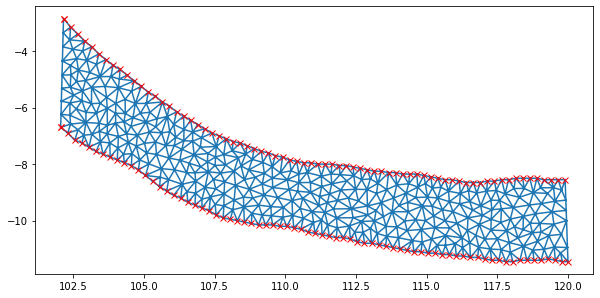

788 triangles


In [7]:
# create the mesh based on the input polygon. 
# Edge refinement is controlled by the 'nkeep' value in the cell above.
# Interior refinement is controlled by the function needs_refinement in slabMesh.
# You may have to manually adjust the hard-coded numbers in that function. 
# See meshPy documentation for more.

# note, meshpy does not like exactly vertical lines, and randomly causes jupyter-lab to crash sometimes. If this happens,
# try changing the 'skip' value in the cell above, to skip some points along the bottom edge to make the lines non-vertical.
# you could also change some values in the refinement function of slabMesh.
# hard to understand why this happens, but also sometimes just running the whole notebook again causes it to succeed.
mesh_points,mesh_tris=slabMesh.make_mesh(Xpoly,Ypoly)

plt.figure(figsize=(10,10))
ax = plt.gca() 
ax.set_aspect(1)

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.plot(Xpoly,Ypoly,'rx')
plt.show()
print(len(mesh_tris),'triangles')

In [8]:
# assign depths to the nodes based on interpolation of the original depths

# conda/jupyter installations to enable interactive plots:
#
# conda install -c conda-forge ipympl
# jupyter labextension install @jupyter-widgets/jupyterlab-manager (must run again, even if installed before)
# jupyter labextension install jupyter-matplotlib
#

#points=np.array([Xcrop.ravel(),Ycrop.ravel()]).T # another ugly array creation
# do the interpolation to get depths
xvals=np.append(Xcrop.ravel(),Xtop)
yvals=np.append(Ycrop.ravel(),Ytop)
zvals=np.append(Zcrop.ravel(),0*Xtop)
mesh_depths = slabMesh.my_griddata(xvals,yvals, zvals, mesh_points[:,0], mesh_points[:,1])

%matplotlib widget 

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect(1)

ax.scatter(Xcrop,Ycrop,Zcrop)
#plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
ax.scatter(mesh_points[:,0],mesh_points[:,1],mesh_depths)
#plt.colorbar()

plt.show()
print(len(mesh_tris),'triangles')


(39648, 2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

788 triangles


In [9]:
#bathymetry correction - subtract shallowest point depth to make it zero
mesh_depths_nobathy = mesh_depths - max(mesh_depths)

# get an (n,3) array of the points
final_points=np.column_stack((mesh_points[:,0],mesh_points[:,1],mesh_depths_nobathy))

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
ax.plot_trisurf(final_points[:,0],final_points[:,1],final_points[:,2],triangles=mesh_tris)

# add an extra point to force aspect ratio - just for viewing. Really annoying that matplotlib doesn't allow 3D axis scaling
ax.scatter(np.mean(Xpoly),np.mean(Ypoly),-300,marker='',color='w')
#plt.colorbar()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
# save mesh to .mat file for Blocks input
fname='slab2_tri_myanmar_14N_25N_extended_sub%d_dep%d.mat'%(nkeep,maxdepth)
print(fname)
slabMesh.save_mesh_for_blocks(final_points,mesh_tris,fname)


slab2_tri_myanmar_14N_25N_extended_sub5_dep35.mat


In [10]:
#save mesh to .tri and .ned format for unicycle input
fname='slab2_tri_myanmar_14N_25N_extended_sub%d_dep%d'%(nkeep,maxdepth)
print(fname)
slabMesh.save_mesh_for_unicycle(final_points,mesh_tris,fname)


slab2_tri_myanmar_14N_25N_extended_sub5_dep35
